In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

In [15]:
df = pd.read_csv('dataseter.csv')

print(df.columns)
print(df.head())

Index(['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC_DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
       'ALCOHOL_CONSUMING', 'COUGHING', 'SHORTNESS_OF_BREATH',
       'SWALLOWING_DIFFICULTY', 'CHEST_PAIN', 'LUNG_CANCER'],
      dtype='object')
  GENDER  AGE SMOKING YELLOW_FINGERS ANXIETY PEER_PRESSURE CHRONIC_DISEASE  \
0      M   65     Yes            Yes     Yes            No              No   
1      F   55     Yes             No      No           Yes             Yes   
2      F   78      No             No     Yes           Yes             Yes   
3      M   60      No            Yes     Yes           Yes              No   
4      F   80     Yes            Yes      No           Yes             Yes   

  FATIGUE ALLERGY WHEEZING ALCOHOL_CONSUMING COUGHING SHORTNESS_OF_BREATH  \
0     Yes      No       No                No       No                  No   
1      No      No       No               Yes      Yes                 Yes   
2      No   

In [16]:
target_column = 'LUNG_CANCER'  
X = df.drop(columns=target_column)  
y = df[target_column]  

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Handle categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Apply one-hot encoding to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ], remainder='passthrough'
)

# Apply the transformations
X = preprocessor.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
def evaluate_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return accuracy, precision, recall

In [19]:
model = LogisticRegression(random_state=42)
selector_kbest = SelectKBest(score_func=chi2, k=5)
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)
X_test_kbest = selector_kbest.transform(X_test)
accuracy_kbest, precision_kbest, recall_kbest = evaluate_model(X_train_kbest, X_test_kbest, y_train, y_test, model)

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

accuracy_original, precision_original, recall_original = evaluate_model(X_train_scaled, X_test_scaled, y_train, y_test, model)

In [21]:
selector_rfe = RFE(estimator=model, n_features_to_select=5, step=1)
X_train_rfe = selector_rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = selector_rfe.transform(X_test_scaled)
accuracy_rfe, precision_rfe, recall_rfe = evaluate_model(X_train_rfe, X_test_rfe, y_train, y_test, model)

In [22]:
model_lasso = Lasso(alpha=0.01)
selector_lasso = SelectFromModel(model_lasso)
X_train_lasso = selector_lasso.fit_transform(X_train_scaled, y_train)
X_test_lasso = selector_lasso.transform(X_test_scaled)
accuracy_lasso, precision_lasso, recall_lasso = evaluate_model(X_train_lasso, X_test_lasso, y_train, y_test, model)

In [23]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)
selector_rf = SelectFromModel(model_rf, threshold='median')
X_train_rf = selector_rf.fit_transform(X_train_scaled, y_train)
X_test_rf = selector_rf.transform(X_test_scaled)
accuracy_rf, precision_rf, recall_rf = evaluate_model(X_train_rf, X_test_rf, y_train, y_test, model)

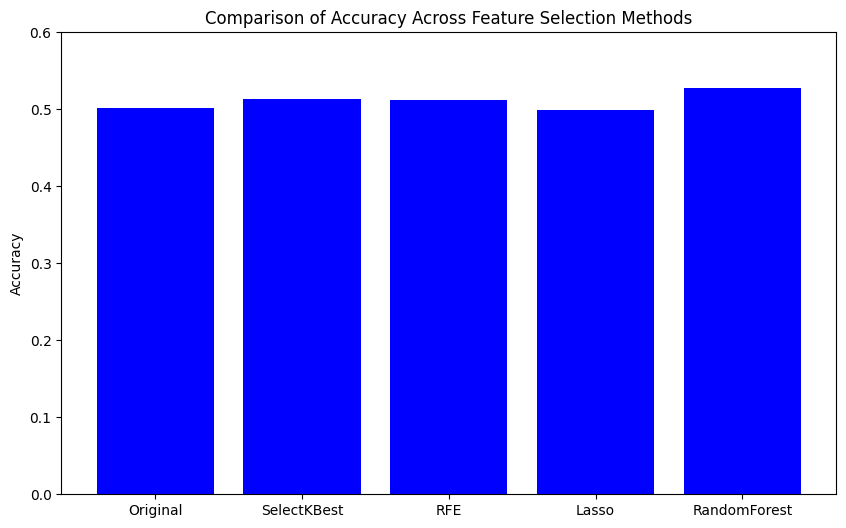

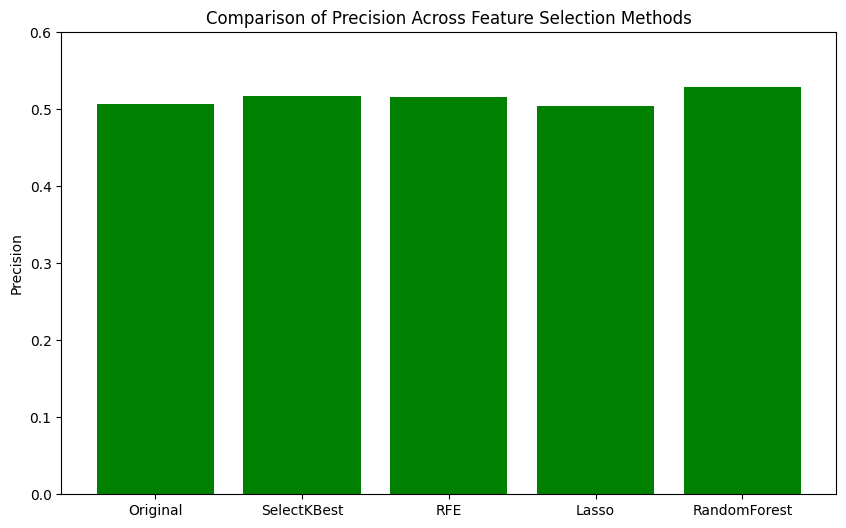

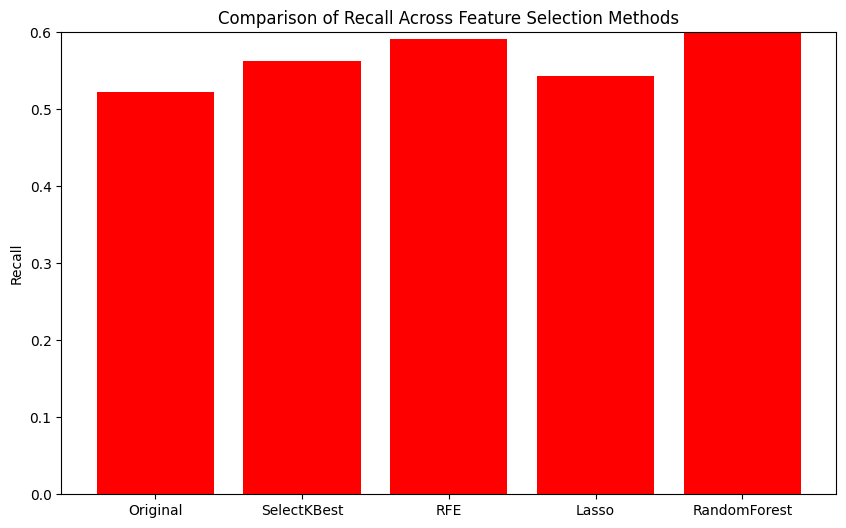

         Method  Accuracy  Precision    Recall
0      Original  0.502222   0.507463  0.523077
1   SelectKBest  0.513333   0.517172  0.562637
2           RFE  0.512222   0.515326  0.591209
3         Lasso  0.498889   0.504082  0.542857
4  RandomForest  0.527778   0.528846  0.604396


In [24]:
methods = ['Original', 'SelectKBest', 'RFE', 'Lasso', 'RandomForest']
accuracies = [accuracy_original, accuracy_kbest, accuracy_rfe, accuracy_lasso, accuracy_rf]
precisions = [precision_original, precision_kbest, precision_rfe, precision_lasso, precision_rf]
recalls = [recall_original, recall_kbest, recall_rfe, recall_lasso, recall_rf]

plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, color='blue')
plt.title('Comparison of Accuracy Across Feature Selection Methods')
plt.ylabel('Accuracy')
plt.ylim(0, 0.6)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(methods, precisions, color='green')
plt.title('Comparison of Precision Across Feature Selection Methods')
plt.ylabel('Precision')
plt.ylim(0, 0.6)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(methods, recalls, color='red')
plt.title('Comparison of Recall Across Feature Selection Methods')
plt.ylabel('Recall')
plt.ylim(0, 0.6)
plt.show()

results = pd.DataFrame({
    'Method': methods,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls
})

print(results)
